In [525]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import csv
from sklearn.linear_model import Ridge


In [526]:
df_hospital=pd.read_csv("processed_data/dublinbikes_james_hospital.csv")
df_portobello=pd.read_csv("processed_data/dublinbikes_portobello.csv")

Lets get some basic features like day of week, weekend, time

In [527]:
def get_basic_features(df:pd.DataFrame):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["DAY OF WEEK"]=df["TIME"].dt.dayofweek-1
    df["HOUR"]=df["TIME"].dt.strftime("%H").astype(int)
    df["MINUTE"]=df["TIME"].dt.strftime("%M").astype(int)

    
    return df

In [528]:
df_hospital_map={}
df_portobello_map={}

Lets add some more complex features using weekly, daily and short-term seasonality trends in the data

For short term trends lets use intervals of 15 min, and get the last three intervals

In [529]:
def get_trend_features(df:pd.DataFrame):
    df["CURRENT AVAILABILITY"] = df["AVAILABLE BIKES"]
    df["5MIN AGO"] = df["AVAILABLE BIKES"].shift(1)
    df["10MIN AGO"] = df["AVAILABLE BIKES"].shift(2)
    df["15MIN AGO"] = df["AVAILABLE BIKES"].shift(3)
    df["20MIN AGO"] = df["AVAILABLE BIKES"].shift(4)
    df["30MIN AGO"] = df["AVAILABLE BIKES"].shift(6)
    df["40MIN AGO"] = df["AVAILABLE BIKES"].shift(8)
    df["50MIN AGO"] = df["AVAILABLE BIKES"].shift(10)
    df["60MIN AGO"] = df["AVAILABLE BIKES"].shift(12)
    df["70MIN AGO"] = df["AVAILABLE BIKES"].shift(14)
    df["80MIN AGO"] = df["AVAILABLE BIKES"].shift(16)
    df["90MIN AGO"] = df["AVAILABLE BIKES"].shift(18)
    df["100MIN AGO"] = df["AVAILABLE BIKES"].shift(20)
    
 
    df.dropna(inplace=True)
    return df

In [530]:
def shift_target_variable(df:pd.DataFrame, prediction_time : int):
    df=df.copy(deep=True)
    prediction_int = np.trunc(prediction_time/5) 
    prediction_int=prediction_int.astype(int)
    df["AVAILABLE BIKES"]=df["AVAILABLE BIKES"].shift(-prediction_int)
    df["2 DAYS AGO"]=df["2 DAYS AGO"].shift(-prediction_int)
    df["1 DAY AGO"]=df["1 DAY AGO"].shift(-prediction_int)
    df.dropna(inplace=True)
    return df

In [531]:
def get_seasonal_features(df:pd.DataFrame):


    df["ONE WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKDAY AGO"].fillna(0,inplace=True)
    df["ONE WEEKENDDAY AGO"] = df.loc[df_hospital["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKENDDAY AGO"].fillna(0, inplace=True)
    df["1 DAY AGO"] = df["ONE WEEKDAY AGO"] + df["ONE WEEKENDDAY AGO"]

    df["2 WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKDAY AGO"].fillna(0,inplace=True)
    df["2 WEEKENDDAY AGO"] = df.loc[df_hospital["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKENDDAY AGO"].fillna(0, inplace=True)
    df["2 DAYS AGO"] = df["2 WEEKDAY AGO"] + df["2 WEEKENDDAY AGO"]

    df["1 WEEK AGO"] = df["AVAILABLE BIKES"].shift(12*24*7)
    df.drop("WEEKEND",inplace=True)
    df.dropna(inplace=True)
    return df

In [532]:
def normalize_features(df:pd.DataFrame):
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"]/df["BIKE STANDS"]
    """df["DAY OF WEEK"] = df["DAY OF WEEK"] / 6
    df["HOUR"] = df["HOUR"] / max(df["HOUR"])
    df["MINUTE"] = df["MINUTE"] / max(df["MINUTE"])"""
    return df

In [533]:
df_hospital["TIME"]=pd.to_datetime(df_hospital["TIME"])
df_hospital["WEEKEND"] = df_hospital["TIME"].dt.dayofweek >=5

df_hospital[500:510]

,TIME,BIKE STANDS,AVAILABLE BIKES,WEEKEND
500,2020-01-29 17:40:02,40,12,False
501,2020-01-29 17:45:02,40,10,False
502,2020-01-29 17:50:02,40,12,False
503,2020-01-29 17:55:02,40,12,False
504,2020-01-29 18:00:02,40,13,False
505,2020-01-29 18:05:02,40,13,False
506,2020-01-29 18:10:02,40,15,False
507,2020-01-29 18:15:02,40,15,False
508,2020-01-29 18:20:02,40,14,False
509,2020-01-29 18:25:02,40,14,False


In [534]:


 
df_hospital["TIME"]=pd.to_datetime(df_hospital["TIME"])
df_portobello["TIME"]=pd.to_datetime(df_portobello["TIME"])
df_hospital.set_index("TIME",inplace=True,drop=True)
df_portobello.set_index("TIME",inplace=True,drop=True)



df_hospital=normalize_features(df_hospital)
df_portobello=normalize_features(df_portobello)


df_hospital=get_trend_features(df_hospital)
df_portobello=get_trend_features(df_portobello)



for key in df_hospital_map:
    print(key)
    df_hospital_map[key] = get_seasonal_features(df_hospital_map[key])
    df_portobello_map[key] = get_seasonal_features(df_portobello_map[key])

df_hospital_map["10MIN"]=shift_target_variable(df_hospital_map["10MIN"], prediction_time = 10)
df_portobello_map["10MIN"]=shift_target_variable(df_portobello_map["10MIN"], prediction_time = 10)

df_hospital_map["30MIN"]=shift_target_variable(df_hospital_map["30MIN"], prediction_time = 30)
df_portobello_map["30MIN"]=shift_target_variable(df_portobello_map["30MIN"], prediction_time = 30)

df_hospital_map["60MIN"]=shift_target_variable(df_hospital_map["60MIN"], prediction_time = 60)
df_portobello_map["60MIN"]=shift_target_variable(df_portobello_map["60MIN"], prediction_time =  60)







KeyError: '10MIN'

In [ ]:
df_hospital.loc[df_hospital["WEEKEND"]==False]

,BIKE STANDS,AVAILABLE BIKES,WEEKEND
TIME,,,
2020-01-28 00:00:02,40,0.50,False
2020-01-28 00:05:02,40,0.50,False
2020-01-28 00:10:02,40,0.50,False
2020-01-28 00:15:02,40,0.50,False
2020-01-28 00:20:02,40,0.50,False
...,...,...,...
2020-03-12 23:35:02,40,0.55,False
2020-03-12 23:40:02,40,0.55,False
2020-03-12 23:45:02,40,0.55,False


In [ ]:
df_hospital[2200:2220]

,BIKE STANDS,AVAILABLE BIKES,WEEKEND,ONE WEEKDAY AGO,ONE WEEKENDDAY AGO,ONE DAY AGO,1 DAY AGO
TIME,,,,,,,
2020-02-04 15:20:02,40,0.275,False,0.425,0.0,0.425,0.425
2020-02-04 15:25:02,40,0.275,False,0.425,0.0,0.425,0.425
2020-02-04 15:30:03,40,0.275,False,0.400,0.0,0.400,0.400
2020-02-04 15:35:02,40,0.275,False,0.375,0.0,0.375,0.375
2020-02-04 15:40:02,40,0.275,False,0.375,0.0,0.375,0.375
2020-02-04 15:45:02,40,0.275,False,0.375,0.0,0.375,0.375
2020-02-04 15:50:02,40,0.300,False,0.375,0.0,0.375,0.375
2020-02-04 15:55:02,40,0.300,False,0.375,0.0,0.375,0.375
2020-02-04 16:00:02,40,0.325,False,0.375,0.0,0.375,0.375


In [ ]:
df_hospital.loc[df_hospital["ONE DAY AGO"].isna()]

,BIKE STANDS,AVAILABLE BIKES,WEEKEND,ONE WEEKDAY AGO,ONE WEEKENDDAY AGO,ONE DAY AGO,1 DAY AGO
TIME,,,,,,,


In [ ]:
def get_X_and_y(df:map):
    X={}
    y={}
    y["10MIN"]=df["10MIN"]["AVAILABLE BIKES"]
    X["10MIN"] = df["10MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["30MIN"]=df["30MIN"]["AVAILABLE BIKES"]
    X["30MIN"] = df["30MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["60MIN"]=df["60MIN"]["AVAILABLE BIKES"]
    X["60MIN"] = df["60MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    return X,y

In [ ]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)


KeyError: '10MIN'

In [ ]:
ridge_model_portobello = {}
ridge_model_hospital = {}

for key in X_portobello.keys():
    ridge_model_portobello[key]=Ridge().fit(X_portobello[key],y_portobello[key])
    ridge_model_hospital[key]=Ridge().fit(X_hospital[key],y_hospital[key])



In [ ]:
hospital_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_hospital["10MIN"].coef_,
"30 Min Prediciton":ridge_model_hospital["30MIN"].coef_,
"60 Min Prediciton":ridge_model_hospital["60MIN"].coef_
})

portobello_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_portobello["10MIN"].coef_,
"30 Min Prediciton":ridge_model_portobello["30MIN"].coef_,
"60 Min Prediciton":ridge_model_portobello["60MIN"].coef_
})

hospital_features_df.set_index("Feature Name",inplace=True)
portobello_features_df.set_index("Feature Name",inplace=True)


hospital_features_df

ValueError: All arrays must be of the same length

Text(0.5, 1.0, 'St James Hospital Bike Station')

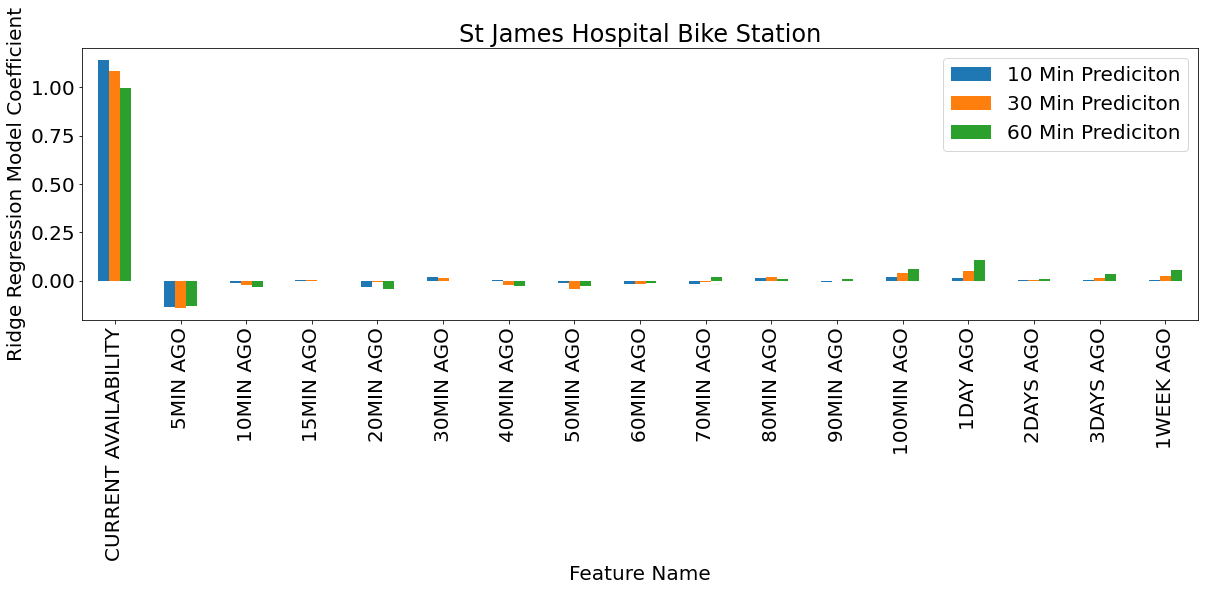

In [ ]:
plt.rc('font',size=20)
hospital_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("St James Hospital Bike Station")

Text(0.5, 1.0, 'Portobello Bike Station')

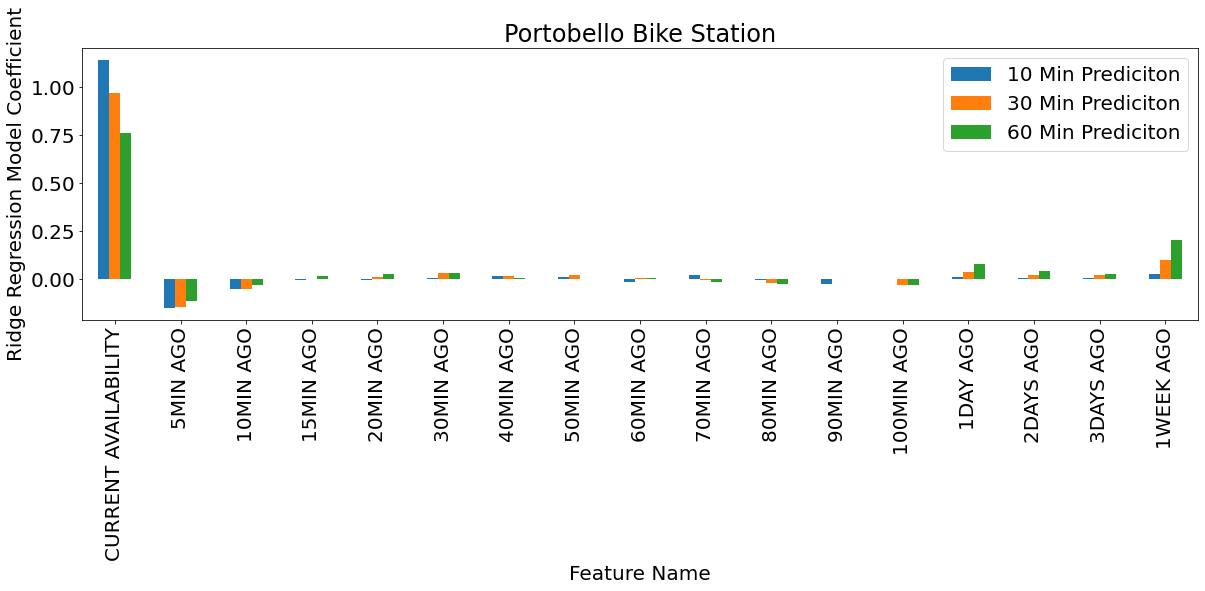

In [ ]:
plt.rc('font',size=20)
portobello_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("Portobello Bike Station")